# Main Notebook for Wireless Networks and Communication Project

This project aims to build an intelligent system for detecting and preventing network attacks and threats using artificial intelligence and machine learning. By analyzing detailed traffic logs and packet metadata, the system can identify patterns of malicious behavior such as port scanning, unusual packet flows, or suspicious connection states. The core idea is to leverage predictive models that learn from historical traffic data to proactively detect anomalies and potential intrusions. This approach not only supports in-depth traffic analysis but also enables real-time threat prevention, contributing to stronger and smarter network security infrastructures.  
This notebook will showcase the dataset and the steps followed to create the model for prediction.

# 0. Libraries and Needed Tools

Let us import some needed `Python` libraries

In [46]:
!pip install pyarrow
!pip install scikit-learn
!pip install xgboost


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
^C
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# 1. Dataset

### 1.1. Data Description

For this study, we will be using an academic intrusion detection dataset.  
The data used for this study is accessible via the following link: [Kaggle](https://www.kaggle.com/datasets/engraqeel/iot23preprocesseddata)

In [ ]:
# read and concatenate them into one DataFrame
data = pd.read_csv('/Users/faycalamrouche/Desktop/wireless-prjct/data/iot23_combined_new.csv', index_col=False)

# preview the result
data.head()

/var/folders/_f/5f5skv_d26v8ffs4fs8bjq900000gn/T/ipykernel_2749/3274358630.py:2: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/faycalamrouche/Desktop/wireless-prjct/data/iot23_combined_new.csv', index_col=False)


,Unnamed: 0,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,0,1.536227e+09,CeqqKl3hyLQmO8LK98,192.168.100.111,17576.0,78.1.220.212,8081.0,tcp,-,0.000003,...,S0,-,-,0.0,S,2.0,80.0,0.0,0.0,PartOfAHorizontalPortScan
1,1,1.536227e+09,C2oHQWo1EFGH8D9x7,192.168.100.111,17576.0,152.84.7.111,8081.0,tcp,-,0.000002,...,S0,-,-,0.0,S,2.0,80.0,0.0,0.0,PartOfAHorizontalPortScan
2,2,1.536227e+09,CJLVjs4BByG04mczXc,192.168.100.111,17576.0,173.36.41.67,8081.0,tcp,-,0.000002,...,S0,-,-,0.0,S,2.0,80.0,0.0,0.0,PartOfAHorizontalPortScan
3,3,1.536227e+09,C0z4uS9AWHDH2s4S7,192.168.100.111,17576.0,87.13.21.104,8081.0,tcp,-,0.000002,...,S0,-,-,0.0,S,2.0,80.0,0.0,0.0,PartOfAHorizontalPortScan
4,4,1.536227e+09,CxbNVk3liFNUIlqSPi,192.168.100.111,17576.0,99.110.163.140,8081.0,tcp,-,0.000002,...,S0,-,-,0.0,S,2.0,80.0,0.0,0.0,PartOfAHorizontalPortScan


### 1.2. Exploratory Data Analysis

In [ ]:
print(f"Total rows: {len(data)}")
print(f"Total columns: {len(data.columns)}")

Total rows: 6046623
Total columns: 22


In [ ]:
data.describe()

,Unnamed: 0,ts,id.orig_p,id.resp_p,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,6.046623e+06,6.046623e+06,6.046623e+06,6.046623e+06,6.046623e+06,6.046623e+06,6.046623e+06,6.046623e+06,6.046623e+06
mean,2.481276e+05,1.546218e+09,3.603571e+04,1.897556e+04,5.090908e-02,4.375558e+01,1.907296e+03,5.875329e-02,6.426806e+01
std,1.453392e+05,9.546116e+06,1.776917e+04,2.273121e+04,2.108386e+01,3.534218e+04,1.392789e+06,9.774769e+01,1.422790e+05
min,0.000000e+00,1.532101e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.220850e+05,1.537541e+09,2.256800e+04,2.300000e+01,0.000000e+00,1.000000e+00,4.000000e+01,0.000000e+00,0.000000e+00
50%,2.480560e+05,1.545433e+09,3.618500e+04,8.081000e+03,0.000000e+00,1.000000e+00,4.000000e+01,0.000000e+00,0.000000e+00
75%,3.740270e+05,1.551383e+09,5.084000e+04,3.721500e+04,0.000000e+00,2.000000e+00,8.000000e+01,0.000000e+00,0.000000e+00
max,4.999980e+05,1.569018e+09,6.553500e+04,6.549000e+04,2.027200e+04,6.602735e+07,1.914793e+09,2.394840e+05,3.496187e+08


In [ ]:
data.label.unique()

array(['PartOfAHorizontalPortScan', 'Okiru', 'DDoS', 'C&C-HeartBeat',
       'Benign', 'C&C-Torii', 'C&C', 'C&C-FileDownload', 'Okiru-Attack',
       'Attack', 'FileDownload', 'C&C-HeartBeat-FileDownload',
       'C&C-Mirai'], dtype=object)

- **Benign:** Normal, non-malicious network traffic that does not pose a security threat. This label is crucial for training models to distinguish between harmful and harmless activities.  
- **PartOfAHorizontalPortScan:** A large number of connection attempts to various ports across multiple hosts, typically to discover open ports and vulnerable services. This activity is a common precursor to more targeted attacks.  
- **Okiru:** Associated with the Okiru malware, which targets IoT devices. Okiru is known for its capability to infect routers and other connected devices.  
- **DDoS (Distributed Denial of Service):** Traffic patterns indicative of a DDoS attack, where multiple systems flood the bandwidth or resources of a targeted system, usually one or more web servers.  
- **C&C (Command and Control):** Traffic associated with command and control servers, which attackers use to communicate with and control compromised systems within a botnet or malware-infected network.  
- **C&C-HeartBeat:** A specific type of C&C traffic that involves periodic signals (heartbeats) sent from compromised devices to a C&C server to indicate the device is still active and connected.  
- **Attack:** A general label for traffic that is part of a network attack, which could involve unauthorized access, data exfiltration, or other malicious activities.  
- **C&C-FileDownload:** Traffic indicating that a compromised device is downloading files from a C&C server, potentially indicating the download of malware, updates to existing malware, or malicious configurations.  
- **C&C-Torii:** Activity related to the Torii botnet, which is known for its sophisticated design and versatility in targeting various platforms and devices.  
- **FileDownload:** Indicates the download of files, which in this context may be considered suspicious or part of malicious activities, especially if associated with known malware distribution patterns.  
- **C&C-HeartBeat-FileDownload:** A combination of heartbeats to a C&C server and file downloads from the same, indicating ongoing control and updating of malware or malicious tools on compromised devices.  
- **Okiru-Attack:** Specific attack patterns associated with the Okiru malware, likely indicating active exploitation attempts or malicious activities carried out by infected devices.  
- **C&C-Mirai:** Traffic related to the Mirai botnet, which infects IoT devices to perform large-scale DDoS attacks. Mirai is notorious for exploiting default username and password combinations on IoT devices.

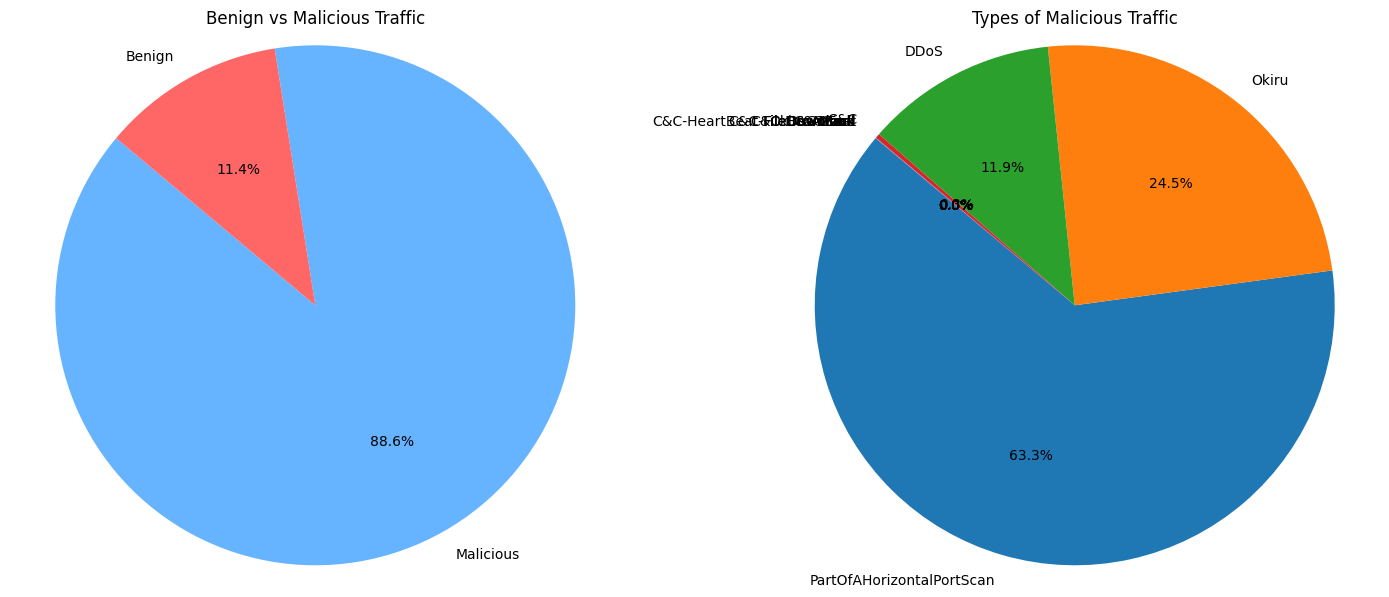

In [ ]:
# classify labels
data['label_type'] = data['label'].apply(lambda x: 'Benign' if 'benign' in x.lower() else 'Malicious')

# count for Benign vs Malicious
label_type_counts = data['label_type'].value_counts()

# count for different malicious labels
malicious_df = data[data['label_type'] == 'Malicious']
malicious_label_counts = malicious_df['label'].value_counts()

# plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# pie chart: Benign vs Malicious
axs[0].pie(label_type_counts, labels=label_type_counts.index, autopct='%1.1f%%',
           startangle=140, colors=['#66b3ff', '#ff6666'])
axs[0].set_title('Benign vs Malicious Traffic')
axs[0].axis('equal')

# pie chart: Malicious Breakdown
axs[1].pie(malicious_label_counts, labels=malicious_label_counts.index, autopct='%1.1f%%',
           startangle=140)
axs[1].set_title('Types of Malicious Traffic')
axs[1].axis('equal')

plt.tight_layout()
plt.show()

# cleanup
data.drop(columns=['label_type'], inplace=True)


This dataset exhibits a significant class imbalance:

- Class $0$ (Benign) accounts for 11.4% of the data.
- Class $1$ (Malicious) makes up only 88.6%.

As a result, a naive model that always predicts the majority class (Class 0) would already achieve an accuracy of 88.6%.

To be considered effective, any machine learning or deep learning model applied to this dataset must outperform this baseline by accurately detecting instances of the minority class (Class 1). Successfully identifying these malicious samples is crucial to demonstrating the model’s real predictive capability.

### 1.3. Target Columns Preprocessing

In [ ]:
data.label.unique()

array(['PartOfAHorizontalPortScan', 'Okiru', 'DDoS', 'C&C-HeartBeat',
       'Benign', 'C&C-Torii', 'C&C', 'C&C-FileDownload', 'Okiru-Attack',
       'Attack', 'FileDownload', 'C&C-HeartBeat-FileDownload',
       'C&C-Mirai'], dtype=object)

In [ ]:
# define attack groups and how they map
label_mapping = {
    'C&C': 'C&C Attack',
    'C&C-HeartBeat': 'C&C Attack',
    'C&C-Torii': 'C&C Attack',
    'C&C-FileDownload': 'C&C Attack',
    'C&C-HeartBeat-FileDownload': 'C&C Attack',
    'C&C-Mirai': 'C&C Attack',
    'Okiru': 'Okiru',
    'Okiru-Attack': 'Okiru',
    'DDoS': 'DDoS Attack',
    'PartOfAHorizontalPortScan': 'Port Scanning',
    'FileDownload': 'File Download Attack',
    'Attack': 'General Malicious Attack',
    'Benign': 'Benign'
}

data['label'] = data['label'].map(label_mapping).fillna('Unknown')
data.label.value_counts()


label
Port Scanning               3389036
Okiru                       1313015
Benign                       688812
DDoS Attack                  638506
C&C Attack                    16703
General Malicious Attack        538
File Download Attack             13
Name: count, dtype: int64

In [12]:
data = data.rename(columns={'label': 'threat'})

In [ ]:
# map 'Benign' to 0 and everything else to 1
data['label'] = data['threat'].map(lambda x: 0 if x == 'Benign' else 1)
data['label'] = data['label'].astype(dtype=np.int32)
print(data['label'].value_counts())

label
1    5357811
0     688812
Name: count, dtype: int64


### 1.4 Columns Filtering

Here, we will remove all non-necessary columns for our prediction.

In [ ]:
non_useful_columns = ['Unnamed: 0', 'ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'service', 'local_orig', 'local_resp', 'history']

data.drop(non_useful_columns, axis=1, inplace=True)
data.head()

,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,threat,label
0,tcp,0.000003,0,0,S0,0.0,2.0,80.0,0.0,0.0,Port Scanning,1
1,tcp,0.000002,0,0,S0,0.0,2.0,80.0,0.0,0.0,Port Scanning,1
2,tcp,0.000002,0,0,S0,0.0,2.0,80.0,0.0,0.0,Port Scanning,1
3,tcp,0.000002,0,0,S0,0.0,2.0,80.0,0.0,0.0,Port Scanning,1
4,tcp,0.000002,0,0,S0,0.0,2.0,80.0,0.0,0.0,Port Scanning,1


### 1.5 Data Balancing

Since or data is highly imbalanced, we need to enforce a technique to balance our data. One of the techniques we will use is subsampling -undersampling-.

In [ ]:
def subsample(df, threat_col="threat", label_col="label", random_state=0):
    df_benign = df[df[label_col] == 0]
    df_malicious = df[df[label_col] == 1]

    benign_count = len(df_benign)
    malicious_threat_counts = df_malicious[threat_col].value_counts()

    print(f"Before subsampling:")
    print(f"- Benign: {benign_count}")
    print(f"- Malicious: {len(df_malicious)}")

    # desired total malicious count
    max_malicious = benign_count

    # proportional allocation of malicious samples
    total_original_malicious = malicious_threat_counts.sum()
    sampling_ratios = malicious_threat_counts / total_original_malicious
    target_threat_counts = (sampling_ratios * max_malicious).astype(int)

    # sample from each threat proportionally
    balanced_malicious = []

    for threat, target_count in target_threat_counts.items():
        df_threat = df_malicious[df_malicious[threat_col] == threat]
        n_available = len(df_threat)
        n_sample = min(target_count, n_available)
        balanced_malicious.append(df_threat.sample(n=n_sample, random_state=random_state))

    df_malicious_balanced = pd.concat(balanced_malicious)
    df_balanced = pd.concat([df_benign, df_malicious_balanced])
    df_balanced = df_balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)

    print(f"\nAfter subsampling:")
    print(f"- Benign: {len(df_benign)}")
    print(f"- Malicious: {len(df_malicious_balanced)}")
    print(f"- Total: {len(df_balanced)}")

    print("\nRemaining threats distribution:")
    print(df_balanced[threat_col].value_counts())

    return df_balanced



data = subsample(data)

Before subsampling:
- Benign: 688812
- Malicious: 5357811

After subsampling:
- Benign: 688812
- Malicious: 688809
- Total: 1377621

Remaining threats distribution:
threat
Benign                      688812
Port Scanning               435701
Okiru                       168804
DDoS Attack                  82087
C&C Attack                    2147
General Malicious Attack        69
File Download Attack             1
Name: count, dtype: int64


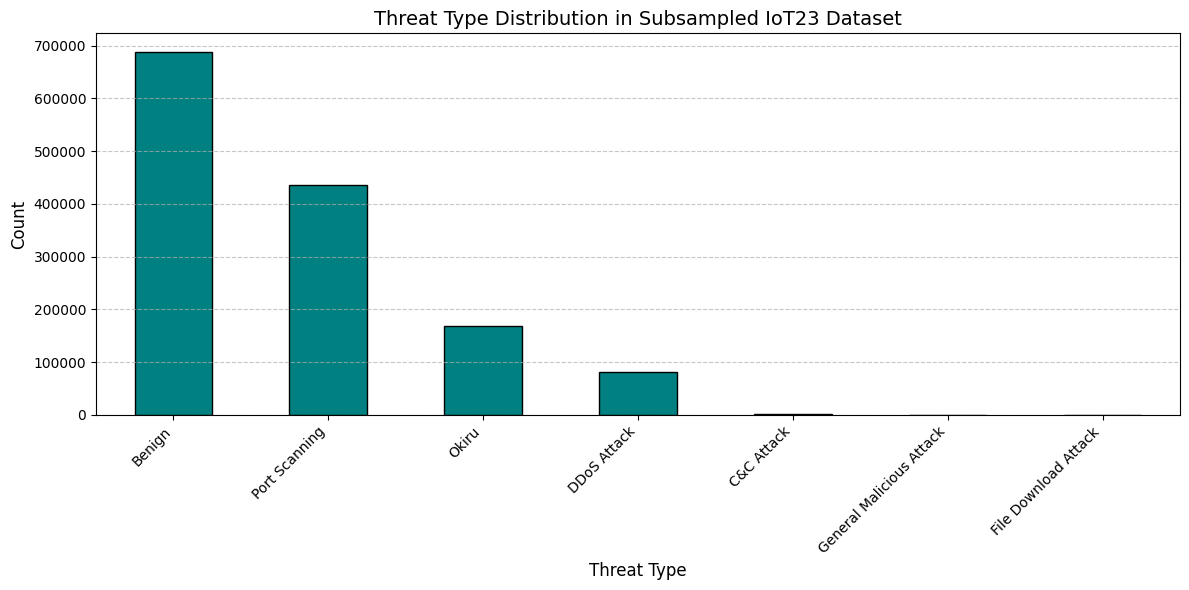

In [ ]:
# count threat types
threat_counts = data['threat'].value_counts()

# plot
plt.figure(figsize=(12, 6))
threat_counts.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Threat Type Distribution in Subsampled IoT23 Dataset', fontsize=14)
plt.xlabel('Threat Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

### 1.6 Handling Empty Values

We will try to handle empty values, and in our dataset, some empty values are marked with '-'.

#### **1.6.1 Identify Empty Values**

In [ ]:
preprocessed_data = data.copy()

print("Empty values before replacing:")
print(preprocessed_data.isna().sum())

# replace
preprocessed_data = preprocessed_data.replace(['-'], np.nan)

print("\nAfter replacing '-':")
print(preprocessed_data.isna().sum())

Empty values before replacing:
proto            0
duration         0
orig_bytes       0
resp_bytes       0
conn_state       0
missed_bytes     0
orig_pkts        0
orig_ip_bytes    0
resp_pkts        0
resp_ip_bytes    0
threat           0
label            0
dtype: int64

After replacing '-':
proto                 0
duration         853550
orig_bytes       853550
resp_bytes       853550
conn_state            0
missed_bytes          0
orig_pkts             0
orig_ip_bytes         0
resp_pkts             0
resp_ip_bytes         0
threat                0
label                 0
dtype: int64


#### **1.6.2 One-Hot Encoding**

In [ ]:
# Make 'proto', 'service', 'conn_state', 'history' as One-Hot Encoded
print(f"Before One-Hot Encoding: {preprocessed_data.columns}")

def encode(df, column_name):
   df[column_name] = df[column_name].astype(str)
   dummies = pd.get_dummies(df[[column_name]], dummy_na=True).astype(int)
   res = pd.concat([df, dummies], axis=1)
   res = res.drop([column_name], axis=1)
   return res

# columns_to_encode = ['proto', 'conn_state']
columns_to_encode = ['proto', 'conn_state']

for column in columns_to_encode:
   preprocessed_data = encode(preprocessed_data, column)

print(f"\nAfter One-Hot Encoding: {preprocessed_data.columns}")

Before One-Hot Encoding: Index(['proto', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state',
       'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts',
       'resp_ip_bytes', 'threat', 'label'],
      dtype='object')

After One-Hot Encoding: Index(['duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts',
       'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'threat', 'label',
       'proto_icmp', 'proto_tcp', 'proto_udp', 'proto_nan', 'conn_state_OTH',
       'conn_state_REJ', 'conn_state_RSTO', 'conn_state_RSTOS0',
       'conn_state_RSTR', 'conn_state_RSTRH', 'conn_state_S0', 'conn_state_S1',
       'conn_state_S2', 'conn_state_S3', 'conn_state_SF', 'conn_state_SH',
       'conn_state_SHR', 'conn_state_nan'],
      dtype='object')


#### **1.6.3 Data Imputation: Filling Missing Numeric and Categorical Values**

In [ ]:
# Separate numeric and categorical columns
numeric_cols = preprocessed_data.select_dtypes(include=['number']).columns
categorical_cols = preprocessed_data.select_dtypes(include=['object']).columns

# Show the number of NaNs before replacing
print("Number of NaN values before replacing:")
print(preprocessed_data.isna().sum()[preprocessed_data.isna().sum() > 0])

# fill NaNs in numeric columns with the median
for column in numeric_cols:
   median_val = preprocessed_data[column].median()
   preprocessed_data[column] = preprocessed_data[column].fillna(median_val)

# Fill NaNs in categorical columns with the mode
for column in categorical_cols:
   mode_val = preprocessed_data[column].mode()[0]
   preprocessed_data[column] = preprocessed_data[column].fillna(mode_val)

# Show the number of NaNs after replacing
print("\nNumber of NaN values after replacing:")
print(preprocessed_data.isna().sum()[preprocessed_data.isna().sum() > 0])

print("\nDataset size:", preprocessed_data.shape)
preprocessed_data.head()


Number of NaN values before replacing:
duration      853550
orig_bytes    853550
resp_bytes    853550
dtype: int64

Number of NaN values after replacing:
Series([], dtype: int64)

Dataset size: (1377621, 28)


,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,threat,label,...,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR,conn_state_nan
0,3.14872,0,0,0.0,6.0,360.0,0.0,0.0,Port Scanning,1,...,0,0,1,0,0,0,0,0,0,0
1,3.100739,0,0,0.0,3.0,180.0,0.0,0.0,Benign,0,...,0,0,1,0,0,0,0,0,0,0
2,0.000002,0,0,0.0,1.0,40.0,0.0,0.0,Port Scanning,1,...,0,0,1,0,0,0,0,0,0,0
3,0.000002,0,0,0.0,1.0,40.0,0.0,0.0,Benign,0,...,0,0,1,0,0,0,0,0,0,0
4,0.000006,0,0,0.0,2.0,80.0,0.0,0.0,Port Scanning,1,...,0,0,1,0,0,0,0,0,0,0


#### **1.6.4 Removing Columns Having Only Zeros**

In [ ]:
empty_columns = data.columns[(data == 0).all()]
print(f"Empty columns: {empty_columns}")
data.drop(empty_columns, axis=1, inplace=True)
print(data.shape)

Empty columns: Index([], dtype='object')
(1377621, 12)


### 1.7 Train-Test Split

When building a deep learning model, we split the dataset into three parts: training, validation, and test sets. The training set is used to teach the model, the validation set helps fine-tune it and monitor for overfitting, and the test set is used at the end to evaluate how well the model performs on completely unseen data.

Since this dataset is imbalanced (most samples are from Class 0), we use stratified splitting to make sure that the class proportions (Class 0 and Class 1) are preserved across all splits. This ensures that each subset represents the overall distribution of the data.

Here, we split 80% of the data for training, and the remaining 20% is for the test.

Now, at this stage, we will resume working with our main data since we will build a full pipeline that holds the whole custom processor and model class.

In [ ]:
from sklearn.model_selection import train_test_split

# features
X = data.drop(columns=['label', 'threat'])

# targets
y_label = data['label']
y_threat = data['threat']

# split features and both targets into train and test
X_train, X_test, y_label_train, y_label_test, y_threat_train, y_threat_test = train_test_split(
    X, y_label, y_threat, test_size=0.2, random_state=42, stratify=y_label
)

# check sizes
print(f"Training Set: {X_train.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")


Training Set: 1102096 samples
Test Set: 275525 samples


### 1.8 Scaling

When working with real-world data like the CIC-IDS-2017 dataset, it's common to encounter outliers—especially in network traffic where attacks can cause unusual spikes in certain features. To handle this, we apply the Robust Scaler, which is designed to reduce the effect of these outliers during preprocessing.

Instead of using the mean and standard deviation (like StandardScaler), the Robust Scaler uses the median and the interquartile range (IQR) to scale the data. This makes it more reliable when the data includes anomalies.

The formula:
$$
X_{\text{scaled}} = \frac{X - \text{median}(X)}{\text{IQR}(X)}
$$

This, will be applied in the pipeline.

# 2. Modelling

### 2.1 Processing Pipeline

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin


class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.numeric_cols = None
        self.columns_to_encode = ['proto', 'conn_state']
        self.dummy_columns = []
        self.columns_after_processing = None

    def fit(self, X, y=None):
        X = X.copy()
        X.replace(['-'], np.nan, inplace=True)

        # Encode categorical variables
        for col in self.columns_to_encode:
            if col in X.columns:
                X[col] = X[col].astype(str)
                dummies = pd.get_dummies(X[[col]], dummy_na=True).astype(int)
                self.dummy_columns.extend([(col, dummy_col) for dummy_col in dummies.columns])
                X = pd.concat([X, dummies], axis=1)
                X.drop(columns=col, inplace=True)

        # Convert other object columns to numeric
        for col in X.columns:
            if X.dtypes.loc[col] == "object" and col not in ["label", "threat"]:
                X[col] = pd.to_numeric(X[col], errors="coerce")

        # Fill missing numeric values
        self.numeric_cols = X.select_dtypes(include="number").columns.tolist()
        X[self.numeric_cols] = X[self.numeric_cols].fillna(X[self.numeric_cols].median())

        # Drop columns that are entirely 0
        X = X.loc[:, (X != 0).any(axis=0)]

        self.columns_after_processing = X.columns
        return self

    def transform(self, X):
        X = X.copy()
        X = X.replace(['-'], np.nan)

        # Encode categorical variables
        for col in self.columns_to_encode:
            if col in X.columns:
                X[col] = X[col].astype(str)
                dummies = pd.get_dummies(X[[col]], dummy_na=True).astype(int)
                for original, dummy_col in self.dummy_columns:
                    if original == col and dummy_col not in dummies.columns:
                        dummies[dummy_col] = 0
                X = pd.concat([X, dummies], axis=1)
                X.drop(columns=col, inplace=True)

        # Convert object columns to numeric
        for col in X.columns:
            if X.dtypes.loc[col] == "object" and col not in ["label", "threat"]:
                X[col] = pd.to_numeric(X[col], errors="coerce")

        # Fill missing values
        for col in self.numeric_cols:
            if col in X.columns:
                X[col] = X[col].fillna(X[col].median())

        # Align columns
        X_aligned = pd.DataFrame(index=X.index)
        for col in self.columns_after_processing:
            X_aligned[col] = X[col] if col in X.columns else 0

        return X_aligned

### 2.2 Approach One: One-Step Classification

This is a very simple and naive approach that tries to classify the threat target.

In [23]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

class ThreatClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model=None):
        self.model = model
        self.label_encoder = LabelEncoder()
        self.classes_ = None

    def fit(self, X, y):
        # Encode string labels if necessary
        if y.dtype == object or isinstance(y.iloc[0], str):
            y = self.label_encoder.fit_transform(y)
            self.classes_ = self.label_encoder.classes_
        else:
            self.label_encoder = None  # No need to decode later if already numeric
        self.model.fit(X, y)
        return self

    def predict(self, X):
        preds = self.model.predict(X)
        # Decode if label encoder was used
        if self.label_encoder:
            preds = self.label_encoder.inverse_transform(preds)
        return preds

    def evaluate(self, X_val, y_val):
        y_pred = self.predict(X_val)
        # Align labels if label encoder was used
        if self.label_encoder and (y_val.dtype == object or isinstance(y_val.iloc[0], str)):
            y_val = self.label_encoder.transform(y_val)

        acc = accuracy_score(y_val, self.label_encoder.transform(y_pred) if self.label_encoder else y_pred)
        f1 = f1_score(y_val, self.label_encoder.transform(y_pred) if self.label_encoder else y_pred, average='macro', zero_division=0)
        prec = precision_score(y_val, self.label_encoder.transform(y_pred) if self.label_encoder else y_pred, average='macro', zero_division=0)
        rec = recall_score(y_val, self.label_encoder.transform(y_pred) if self.label_encoder else y_pred, average='macro', zero_division=0)

        print("=== Evaluation Metrics (Threat Classification) ===")
        print(f"Accuracy         : {acc:.4f}")
        print(f"F1 Score (Macro) : {f1:.4f}")
        print(f"Precision (Macro): {prec:.4f}")
        print(f"Recall (Macro)   : {rec:.4f}")
        
        return acc, f1, prec, rec


In [ ]:

from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Create pipeline
threat_pipeline = Pipeline(
    [
        ("preprocessor", CustomPreprocessor()),
        (
            "classifier",
            ThreatClassifier(
                model=XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            ),
        ),
    ]
)

# Fit the pipeline
threat_pipeline.fit(X_train, y_threat_train)

Pipeline(steps=[('preprocessor', CustomPreprocessor()),
                ('classifier',
                 ThreatClassifier(model=XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=100,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...)))])

In [25]:
import joblib

joblib.dump(threat_pipeline, "threat_classifier_pipeline.joblib")

['threat_classifier_pipeline.joblib']

In [ ]:
y_test_pred = threat_pipeline.predict(X_test)

# Calculate evaluation metrics
acc = accuracy_score(y_threat_test, y_test_pred)
f1 = f1_score(y_threat_test, y_test_pred, average='weighted', zero_division=0)
prec = precision_score(y_threat_test, y_test_pred, average='weighted', zero_division=0)
rec = recall_score(y_threat_test, y_test_pred, average='weighted', zero_division=0)

# Print the evaluation metrics
print("=== Pipeline Evaluation Metrics (Threat Classification - Test Set) ===")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")


=== Pipeline Evaluation Metrics (Threat Classification - Test Set) ===
Accuracy: 0.7444
F1 Score: 0.7101
Precision: 0.7342
Recall: 0.7444


### 2.2 Approach Two: Hierarchical Approach for Network Intrusion Detection

For the Iot23 dataset, we implemented a hierarchical classification model to address the challenges of imbalanced data and multi-class threat classification. Network intrusion detection systems typically face two significant challenges:
- Class Imbalance: Benign network traffic vastly outnumbers malicious traffic.
- Diverse Attack Types: Malicious traffic includes multiple categories of attacks, each with different patterns and characteristics.

Our hierarchical approach breaks down the classification task into two phases:
- Phase 1: Binary classification to distinguish benign from malicious traffic.  
- Phase 2: Multi-class classification to identify specific attack types among samples classified as malicious.

### 2.2 Architecture

Here is the architecture of the solution:  

![Architecture](assets/IDS-ML.png)

### 2.3 Model Selection

#### **2.3.1 Base Model: XGBOOST3.0**
XGBoost (Extreme Gradient Boosting) serves as our primary model for binary classification in our hierarchical approach. This algorithm excels at processing structured data like network traffic features, making it ideal for distinguishing between benign and malicious network activity.  

XGBoost builds upon the gradient boosting framework by sequentially constructing decision trees that learn from previous errors. The model evolves according to:
$$
F_m(x) = F_{m-1}(x) + η·h_m(x)
$$
Where each new tree $h_m$ contributes to improving the previous model iteration (F_{m-1}), regulated by a learning rate (η). This iterative correction process creates a robust ensemble that balances bias and variance effectively.  

XGBoost offers several critical benefits for network security applications which make it particularly well-suited for the first phase of our hierarchical model:

- **Efficient handling of imbalanced data:** Network traffic typically contains far more benign than malicious samples. XGBoost allows weight adjustment for minority classes, improving detection accuracy.
- **Feature importance insights:** The algorithm automatically identifies which network attributes most significantly contribute to detecting malicious activity, enhancing interpretability.
- **Resource efficiency:** Unlike deep learning approaches that demand extensive computational resources, XGBoost performs effectively on standard hardware.
- **Advanced regularization:** Both L1 and L2 regularization prevent overfitting, ensuring the model generalizes well to new attack patterns.
- **Parallel processing capabilities:** Multi-threaded execution enables rapid training and inference on large network traffic datasets.
- **Superior handling of tabular data:** XGBoost excels with structured network flow features without requiring extensive feature engineering.


#### **2.3.2 Threats Model: Multi-class Classification**
The same model was chosen for the second phase due to its effectiveness in multi-class problems:

- **Natural Multi-class Capability:** It naturally handles multi-class problems through voting across ensemble trees.
- **Feature Space Randomization:** It uses bootstrapping and feature bagging to capture diverse patterns among different attack types.
- **Robustness to Overfitting:** The ensemble approach reduces variance and improves generalization across diverse attack patterns.


### 2.4 Performance Evaluation

The hierarchical model is evaluated in two distinct phases:
#### **2.4.1 Phase 1 Metrics (Binary Classification)**

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$  
$$\text{Precision} = \frac{TP}{TP + FP}$$  
$$\text{Recall} = \frac{TP}{TP + FN}$$  
$$\text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$  

#### **2.4.2 Phase 2 Metrics (Multi-class Classification)**

$$\text{Macro-averaged Precision} = \frac{1}{K}\sum_{k=1}^{K}\text{Precision}_k$$
$$\text{Macro-averaged Recall} = \frac{1}{K}\sum_{k=1}^{K}\text{Recall}_k$$
$$\text{Macro-averaged F1-Score} = \frac{1}{K}\sum_{k=1}^{K}\text{F1-Score}_k.$$

Where $K$ is the number of different attack types.

### 2.5 Implementation

Here is the $Python$ implementation of our approach:

In [27]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


class HierarchicalClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, base_model=None, threat_model=None):
        self.base_model = base_model if base_model is not None else XGBClassifier(random_state=42)
        self.threat_model = threat_model if threat_model is not None else XGBClassifier(random_state=42)
        self.threat_encoder = LabelEncoder()

    def fit(self, X, y):
        y_label, y_threat = y
        X = X.reset_index(drop=True)
        y_label = y_label.reset_index(drop=True)
        y_threat = y_threat.reset_index(drop=True)

        # Fit base model
        self.base_model.fit(X, y_label)

        # Encode threat labels
        malicious_mask = y_label == 1
        y_threat_malicious = y_threat[malicious_mask]
        X_malicious = X[malicious_mask]

        y_threat_encoded = self.threat_encoder.fit_transform(y_threat_malicious)
        self.threat_model.fit(X_malicious, y_threat_encoded)

        return self

    def predict(self, X):
        final_predictions, _, _ = self.predict_full(X)
        return final_predictions

    def predict_full(self, X):
        X = X.reset_index(drop=True)
        y_pred_label = self.base_model.predict(X)

        y_pred_threat = [""] * len(y_pred_label)
        malicious_indices = y_pred_label == 1
        malicious_samples = X[malicious_indices]

        if len(malicious_samples) > 0:
            rf_preds = self.threat_model.predict(malicious_samples)
            decoded_preds = self.threat_encoder.inverse_transform(rf_preds)
            for idx, threat in zip(np.where(malicious_indices)[0], decoded_preds):
                y_pred_threat[idx] = threat

        final_predictions = [
            "Benign" if label == 0 else f"Malicious: {threat}"
            for label, threat in zip(y_pred_label, y_pred_threat)
        ]
        return final_predictions, y_pred_label, y_pred_threat

    def predict_binary(self, X):
        """Return just the binary labels (0 for benign, 1 for malicious)"""
        X = X.reset_index(drop=True)
        return self.base_model.predict(X)

    def predict_threat(self, X):
        """Return just the threat types for samples predicted as malicious"""
        X = X.reset_index(drop=True)
        y_pred_label = self.base_model.predict(X)

        y_pred_threat = [""] * len(y_pred_label)
        malicious_indices = y_pred_label == 1
        malicious_samples = X[malicious_indices]

        if len(malicious_samples) > 0:
            rf_preds = self.threat_model.predict(malicious_samples)
            decoded_preds = self.threat_encoder.inverse_transform(rf_preds)
            for idx, threat in zip(np.where(malicious_indices)[0], decoded_preds):
                y_pred_threat[idx] = threat

        return y_pred_threat

    def _print_metrics(self, y_true, y_pred, desc):
        print(f"\n=== {desc} ===")
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred, average="weighted", zero_division=1))
        print("Recall:", recall_score(y_true, y_pred, average="weighted", zero_division=1))
        print("F1 Score:", f1_score(y_true, y_pred, average="weighted", zero_division=1))

    def evaluate(self, X, y_label_true, y_threat_true, phase=""):
        _, y_label_pred, y_threat_pred = self.predict_full(X)

        self._print_metrics(y_label_true, y_label_pred, f"Phase 1 - Binary Classification ({phase})")

        threat_mask = y_label_true == 1
        y_threat_true_filtered = y_threat_true[threat_mask].reset_index(drop=True)
        y_threat_pred_filtered = np.array(y_threat_pred)[threat_mask.values]

        self._print_metrics(y_threat_true_filtered, y_threat_pred_filtered, f"Phase 2 - Threat Classification ({phase})")


In [ ]:
# define pipeline
hierarchical_pipeline = Pipeline([
    ("preprocessor", CustomPreprocessor()),
    ("classifier", HierarchicalClassifier(
        base_model=XGBClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            eval_metric="logloss",
            objective="binary:logistic",
            random_state=42,
        ),
        threat_model=XGBClassifier(
            n_estimators=100,
            max_depth=10,
            learning_rate=0.1,
            eval_metric="mlogloss",
            objective="multi:softmax",
            random_state=42
        )
    )),
])


# fit pipeline
hierarchical_pipeline.fit(X_train, (y_label_train, y_threat_train))


Pipeline(steps=[('preprocessor', CustomPreprocessor()),
                ('classifier',
                 HierarchicalClassifier(base_model=XGBClassifier(base_score=None,
                                                                 booster=None,
                                                                 callbacks=None,
                                                                 colsample_bylevel=None,
                                                                 colsample_bynode=None,
                                                                 colsample_bytree=None,
                                                                 device=None,
                                                                 early_stopping_rounds=None,
                                                                 enable_categorical=False,
                                                                 eval_metric='logloss',
                                                                 feature_types=None,
                                                                 feature_weights=No...
                                                                   feature_weights=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.1,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=10,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=100,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None, ...)))])

In [ ]:
joblib.dump(hierarchical_pipeline, "hierarchical_pipeline.joblib")

['hierarchical_pipeline.joblib']

In [ ]:
def evaluate_pipeline(pipeline, X_raw, y_label, y_threat, phase=""):
    y_label = y_label.reset_index(drop=True)
    y_threat = y_threat.reset_index(drop=True)
    pipeline.named_steps["classifier"].evaluate(
        pipeline.named_steps["preprocessor"].transform(X_raw),
        y_label,
        y_threat,
        phase=phase
    )

evaluate_pipeline(hierarchical_pipeline, X_test, y_label_test, y_threat_test, phase="Test")



=== Phase 1 - Binary Classification (Test) ===
Accuracy: 0.8781780237727974
Precision: 0.9008059645426464
Recall: 0.8781780237727974
F1 Score: 0.8764340703383168

=== Phase 2 - Threat Classification (Test) ===
Accuracy: 0.7293448120671884
Precision: 0.8118571497099821
Recall: 0.7293448120671884
F1 Score: 0.6293719718660138


# 3. Testing

In [31]:
import joblib

# load the model
loaded_pipeline = joblib.load("hierarchical_pipeline.joblib")

### 3.1 Random: Sampled instance

In [ ]:
# Simple way to get and print all predictions
sample_index = 2922
sample = X_train.iloc[[sample_index]]
sample

,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
517831,tcp,3.096732,0,0,S0,0.0,3.0,180.0,0.0,0.0


In [ ]:
preprocessed_sample = loaded_pipeline.named_steps['preprocessor'].transform(sample)
classifier = loaded_pipeline.named_steps['classifier']

print("\nPrediction results:")
print("Full prediction:", classifier.predict(preprocessed_sample)[0])
print("Binary prediction:", classifier.predict_binary(preprocessed_sample)[0])
print("Threat type:", classifier.predict_threat(preprocessed_sample)[0])


Prediction results:
Full prediction: Benign
Binary prediction: 0
Threat type: 


### 3.2 Malicious: Sampled instance

In [34]:
# Simple way to get and print all predictions
sample_index = 2925
sample = X_train.iloc[[sample_index]]
sample

,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
186473,tcp,0.000002,0,0,S0,0.0,2.0,80.0,0.0,0.0


In [ ]:
preprocessed_sample = loaded_pipeline.named_steps['preprocessor'].transform(sample)
classifier = loaded_pipeline.named_steps['classifier']

print("\nPrediction results:")
print("Full prediction:", classifier.predict(preprocessed_sample)[0])
print("Binary prediction:", classifier.predict_binary(preprocessed_sample)[0])
print("Threat type:", classifier.predict_threat(preprocessed_sample)[0])


Prediction results:
Full prediction: Malicious: Port Scanning
Binary prediction: 1
Threat type: Port Scanning


/var/folders/_f/5f5skv_d26v8ffs4fs8bjq900000gn/T/ipykernel_2749/20166181.py:39: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace(['-'], np.nan)


In [48]:
# ==============================================================================
# FINAL WORKING MONITORING SCRIPT
# ==============================================================================
import time
import os
import pandas as pd
from datetime import datetime

# Define Zeek log fields EXACTLY as they appear in your conn.log
ZEEK_FIELDS = [
    "ts", "uid", "id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p",
    "proto", "service", "duration", "orig_bytes", "resp_bytes", "conn_state",
    "local_orig", "local_resp", "missed_bytes", "history", "orig_pkts",
    "orig_ip_bytes", "resp_pkts", "resp_ip_bytes", "tunnel_parents", "ip_proto"
]

def run_inference(pipeline, log_file="./../zeek_logs/conn.log"):
    """Run real-time inference on Zeek conn.log"""
    print("="*50)
    print("Starting Network Traffic Monitor")
    print(f"Monitoring: {os.path.abspath(log_file)}")
    print("="*50 + "\n")
    
    # Initialize state
    last_position = 0
    last_benign_time = datetime.now()
    
    try:
        while True:
            try:
                # Check if file exists and get its size
                if not os.path.exists(log_file):
                    print(f"⚠️ Waiting for log file... ({datetime.now().strftime('%H:%M:%S')})")
                    time.sleep(2)
                    continue
                
                current_size = os.path.getsize(log_file)
                
                # If file shrunk (rotation), reset position
                if current_size < last_position:
                    print("🔁 Detected log rotation - resetting position")
                    last_position = 0
                
                # Only read if file has grown
                if current_size > last_position:
                    with open(log_file, 'r') as f:
                        f.seek(last_position)
                        new_lines = f.readlines()
                        last_position = f.tell()
                        
                        for line in new_lines:
                            if line.startswith('#') or not line.strip():
                                continue
                                
                            try:
                                values = line.strip().split('\t')
                                if len(values) != len(ZEEK_FIELDS):
                                    continue
                                    
                                row = dict(zip(ZEEK_FIELDS, values))
                                
                                # DEBUG: Uncomment to see raw data
                                # print(f"Processing: {row['id.orig_h']}:{row['id.orig_p']} -> {row['id.resp_h']}:{row['id.resp_p']}")
                                
                                # Prepare input features
                                features = {
                                    'proto': row['proto'],
                                    'duration': float(row['duration']) if row['duration'] != '-' else 0,
                                    'orig_bytes': int(row['orig_bytes']) if row['orig_bytes'] != '-' else 0,
                                    'resp_bytes': int(row['resp_bytes']) if row['resp_bytes'] != '-' else 0,
                                    'conn_state': row['conn_state'],
                                    'missed_bytes': int(row['missed_bytes']) if row['missed_bytes'] != '-' else 0,
                                    'orig_pkts': int(row['orig_pkts']) if row['orig_pkts'] != '-' else 0,
                                    'orig_ip_bytes': int(row['orig_ip_bytes']) if row['orig_ip_bytes'] != '-' else 0,
                                    'resp_pkts': int(row['resp_pkts']) if row['resp_pkts'] != '-' else 0,
                                    'resp_ip_bytes': int(row['resp_ip_bytes']) if row['resp_ip_bytes'] != '-' else 0
                                }
                                
                                # Make prediction
                                input_df = pd.DataFrame([features])
                                prediction = pipeline.predict(input_df)[0]
                                
                                # Handle output
                                current_time = datetime.now()
                                if prediction.startswith("Malicious"):
                                    print(f"\n🚨 ALERT: {prediction}")
                                    print(f"  Time: {row['ts']}")
                                    print(f"  Connection: {row['id.orig_h']}:{row['id.orig_p']} → {row['id.resp_h']}:{row['id.resp_p']}")
                                    print(f"  Protocol: {row['proto']} | Duration: {row['duration']}s")
                                elif (current_time - last_benign_time).seconds >= 10:  # Show every 10 sec
                                    print(f"✅ Normal traffic ({current_time.strftime('%H:%M:%S')})")
                                    last_benign_time = current_time
                                    
                            except Exception as e:
                                print(f"⚠️ Error processing line: {str(e)}")
                                continue
                
                time.sleep(1)  # Check for new lines every second
                
            except Exception as e:
                print(f"⚠️ File error: {str(e)}")
                time.sleep(5)
                
    except KeyboardInterrupt:
        print("\n🛑 Stopping monitor...")

# Main execution
print("Loading model...")
try:
    pipeline = joblib.load("hierarchical_pipeline.joblib")
    print("✅ Model loaded successfully!")
    
    log_path = "./../zeek_logs/conn.log"
    if not os.path.exists(log_path):
        print(f"\n❌ Error: Log file not found at {os.path.abspath(log_path)}")
        print("Please verify:")
        print("1. Zeek is running: `ps aux | grep zeek`")
        print("2. The log directory exists: `ls -la ./../zeek_logs/`")
    else:
        print(f"Found log file at {os.path.abspath(log_path)}")
        print(f"Current size: {os.path.getsize(log_path)} bytes")
        print("\nStarting monitoring (Press Ctrl+C to stop)...")
        run_inference(pipeline)
        
except Exception as e:
    print(f"❌ Failed to load model: {str(e)}")

Loading model...
✅ Model loaded successfully!
Found log file at /Users/faycalamrouche/Desktop/wireless-prjct/zeek_logs/conn.log
Current size: 11841 bytes

Starting monitoring (Press Ctrl+C to stop)...
Starting Network Traffic Monitor
Monitoring: /Users/faycalamrouche/Desktop/wireless-prjct/zeek_logs/conn.log



/Users/faycalamrouche/Desktop/wireless-prjct/.venv/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/faycalamrouche/Desktop/wireless-prjct/.venv/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



🚨 ALERT: Malicious: DDoS Attack
  Time: 1744847580.347765
  Connection: 192.168.115.146:62510 → 142.250.201.42:443
  Protocol: tcp | Duration: -s

🚨 ALERT: Malicious: C&C Attack
  Time: 1744847452.544433
  Connection: 192.168.115.146:50750 → 100.27.129.163:443
  Protocol: tcp | Duration: 111.494660s

🚨 ALERT: Malicious: C&C Attack
  Time: 1744847424.612090
  Connection: 192.168.115.146:50788 → 140.82.113.26:443
  Protocol: tcp | Duration: 135.819476s

🚨 ALERT: Malicious: Port Scanning
  Time: 1744848883.190178
  Connection: 192.168.1.198:36097 → 1.96.66.126:37215
  Protocol: tcp | Duration: -s

🚨 ALERT: Malicious: Port Scanning
  Time: 1744848893.336800
  Connection: 192.168.1.200:51260 → 42.136.150.51:23
  Protocol: tcp | Duration: 2e-06s

🚨 ALERT: Malicious: Port Scanning
  Time: 1744848903.494147
  Connection: 192.168.1.193:24159 → 197.93.211.19:8081
  Protocol: tcp | Duration: 5e-06s

🚨 ALERT: Malicious: Port Scanning
  Time: 1744848913.639531
  Connection: 192.168.1.198:36097 → 2

In [50]:
# ==============================================================================
# FINAL WORKING MONITORING SCRIPT WITH SQLITE LOGGING
# ==============================================================================
import time
import os
import pandas as pd
import sqlite3
from datetime import datetime
import joblib  # Added import for joblib

# Define Zeek log fields EXACTLY as they appear in your conn.log
ZEEK_FIELDS = [
    "ts", "uid", "id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p",
    "proto", "service", "duration", "orig_bytes", "resp_bytes", "conn_state",
    "local_orig", "local_resp", "missed_bytes", "history", "orig_pkts",
    "orig_ip_bytes", "resp_pkts", "resp_ip_bytes", "tunnel_parents", "ip_proto"
]

def initialize_database():
    """Initialize SQLite database and create tables"""
    conn = sqlite3.connect('network_traffic.db')
    cursor = conn.cursor()
    
    # Create traffic_log table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS traffic_log (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        timestamp DATETIME,
        source_ip TEXT,
        source_port INTEGER,
        dest_ip TEXT,
        dest_port INTEGER,
        protocol TEXT,
        duration REAL,
        orig_bytes INTEGER,
        resp_bytes INTEGER,
        conn_state TEXT,
        prediction TEXT,
        prediction_time DATETIME
    )
    ''')
    
    # Create alerts table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS alerts (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        timestamp DATETIME,
        source_ip TEXT,
        source_port INTEGER,
        dest_ip TEXT,
        dest_port INTEGER,
        protocol TEXT,
        alert_type TEXT,
        severity TEXT,
        description TEXT
    )
    ''')
    
    conn.commit()
    conn.close()

def log_to_database(row, prediction):
    """Log traffic data and predictions to SQLite database"""
    conn = sqlite3.connect('network_traffic.db')
    cursor = conn.cursor()
    
    try:
        # Insert into traffic_log
        cursor.execute('''
        INSERT INTO traffic_log (
            timestamp, source_ip, source_port, dest_ip, dest_port, protocol,
            duration, orig_bytes, resp_bytes, conn_state, prediction, prediction_time
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            row['ts'], row['id.orig_h'], row['id.orig_p'], row['id.resp_h'], row['id.resp_p'],
            row['proto'], float(row['duration']) if row['duration'] != '-' else 0,
            int(row['orig_bytes']) if row['orig_bytes'] != '-' else 0,
            int(row['resp_bytes']) if row['resp_bytes'] != '-' else 0,
            row['conn_state'], prediction, datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        ))
        
        # If malicious, also log to alerts table
        if prediction.startswith("Malicious"):
            alert_type = prediction.split(":")[0].strip()
            description = prediction.split(":")[1].strip() if ":" in prediction else prediction
            
            cursor.execute('''
            INSERT INTO alerts (
                timestamp, source_ip, source_port, dest_ip, dest_port,
                protocol, alert_type, severity, description
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
            ''', (
                row['ts'], row['id.orig_h'], row['id.orig_p'], row['id.resp_h'], row['id.resp_p'],
                row['proto'], alert_type, "high", description
            ))
        
        conn.commit()
    except Exception as e:
        print(f"⚠️ Database error: {str(e)}")
    finally:
        conn.close()

def run_inference(pipeline, log_file="./../zeek_logs/conn.log"):
    """Run real-time inference on Zeek conn.log"""
    print("="*50)
    print("Starting Network Traffic Monitor")
    print(f"Monitoring: {os.path.abspath(log_file)}")
    print("="*50 + "\n")
    
    # Initialize state
    last_position = 0
    last_benign_time = datetime.now()
    
    try:
        while True:
            try:
                # Check if file exists and get its size
                if not os.path.exists(log_file):
                    print(f"⚠️ Waiting for log file... ({datetime.now().strftime('%H:%M:%S')})")
                    time.sleep(2)
                    continue
                
                current_size = os.path.getsize(log_file)
                
                # If file shrunk (rotation), reset position
                if current_size < last_position:
                    print("🔁 Detected log rotation - resetting position")
                    last_position = 0
                
                # Only read if file has grown
                if current_size > last_position:
                    with open(log_file, 'r') as f:
                        f.seek(last_position)
                        new_lines = f.readlines()
                        last_position = f.tell()
                        
                        for line in new_lines:
                            if line.startswith('#') or not line.strip():
                                continue
                                
                            try:
                                values = line.strip().split('\t')
                                if len(values) != len(ZEEK_FIELDS):
                                    continue
                                    
                                row = dict(zip(ZEEK_FIELDS, values))
                                
                                # DEBUG: Uncomment to see raw data
                                # print(f"Processing: {row['id.orig_h']}:{row['id.orig_p']} -> {row['id.resp_h']}:{row['id.resp_p']}")
                                
                                # Prepare input features
                                features = {
                                    'proto': row['proto'],
                                    'duration': float(row['duration']) if row['duration'] != '-' else 0,
                                    'orig_bytes': int(row['orig_bytes']) if row['orig_bytes'] != '-' else 0,
                                    'resp_bytes': int(row['resp_bytes']) if row['resp_bytes'] != '-' else 0,
                                    'conn_state': row['conn_state'],
                                    'missed_bytes': int(row['missed_bytes']) if row['missed_bytes'] != '-' else 0,
                                    'orig_pkts': int(row['orig_pkts']) if row['orig_pkts'] != '-' else 0,
                                    'orig_ip_bytes': int(row['orig_ip_bytes']) if row['orig_ip_bytes'] != '-' else 0,
                                    'resp_pkts': int(row['resp_pkts']) if row['resp_pkts'] != '-' else 0,
                                    'resp_ip_bytes': int(row['resp_ip_bytes']) if row['resp_ip_bytes'] != '-' else 0
                                }
                                
                                # Make prediction
                                input_df = pd.DataFrame([features])
                                prediction = pipeline.predict(input_df)[0]
                                
                                # Log to database
                                log_to_database(row, prediction)
                                
                                # Handle output
                                current_time = datetime.now()
                                if prediction.startswith("Malicious"):
                                    print(f"\n🚨 ALERT: {prediction}")
                                    print(f"  Time: {row['ts']}")
                                    print(f"  Connection: {row['id.orig_h']}:{row['id.orig_p']} → {row['id.resp_h']}:{row['id.resp_p']}")
                                    print(f"  Protocol: {row['proto']} | Duration: {row['duration']}s")
                                elif (current_time - last_benign_time).seconds >= 10:  # Show every 10 sec
                                    print(f"✅ Normal traffic ({current_time.strftime('%H:%M:%S')})")
                                    last_benign_time = current_time
                                    
                            except Exception as e:
                                print(f"⚠️ Error processing line: {str(e)}")
                                continue
                
                time.sleep(1)  # Check for new lines every second
                
            except Exception as e:
                print(f"⚠️ File error: {str(e)}")
                time.sleep(5)
                
    except KeyboardInterrupt:
        print("\n🛑 Stopping monitor...")

# Main execution
if __name__ == "__main__":
    print("Initializing database...")
    initialize_database()
    
    print("Loading model...")
    try:
        pipeline = joblib.load("hierarchical_pipeline.joblib")
        print("✅ Model loaded successfully!")
        
        log_path = "./../zeek_logs/conn.log"
        if not os.path.exists(log_path):
            print(f"\n❌ Error: Log file not found at {os.path.abspath(log_path)}")
            print("Please verify:")
            print("1. Zeek is running: `ps aux | grep zeek`")
            print("2. The log directory exists: `ls -la ./../zeek_logs/`")
        else:
            print(f"Found log file at {os.path.abspath(log_path)}")
            print(f"Current size: {os.path.getsize(log_path)} bytes")
            print("\nStarting monitoring (Press Ctrl+C to stop)...")
            run_inference(pipeline)
            
    except Exception as e:
        print(f"❌ Failed to load model: {str(e)}")

Initializing database...
Loading model...
✅ Model loaded successfully!
Found log file at /Users/faycalamrouche/Desktop/wireless-prjct/zeek_logs/conn.log
Current size: 13553 bytes

Starting monitoring (Press Ctrl+C to stop)...
Starting Network Traffic Monitor
Monitoring: /Users/faycalamrouche/Desktop/wireless-prjct/zeek_logs/conn.log



/Users/faycalamrouche/Desktop/wireless-prjct/.venv/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/faycalamrouche/Desktop/wireless-prjct/.venv/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



🚨 ALERT: Malicious: DDoS Attack
  Time: 1744847580.347765
  Connection: 192.168.115.146:62510 → 142.250.201.42:443
  Protocol: tcp | Duration: -s

🚨 ALERT: Malicious: C&C Attack
  Time: 1744847452.544433
  Connection: 192.168.115.146:50750 → 100.27.129.163:443
  Protocol: tcp | Duration: 111.494660s

🚨 ALERT: Malicious: C&C Attack
  Time: 1744847424.612090
  Connection: 192.168.115.146:50788 → 140.82.113.26:443
  Protocol: tcp | Duration: 135.819476s

🚨 ALERT: Malicious: Port Scanning
  Time: 1744848883.190178
  Connection: 192.168.1.198:36097 → 1.96.66.126:37215
  Protocol: tcp | Duration: -s

🚨 ALERT: Malicious: Port Scanning
  Time: 1744848893.336800
  Connection: 192.168.1.200:51260 → 42.136.150.51:23
  Protocol: tcp | Duration: 2e-06s

🚨 ALERT: Malicious: Port Scanning
  Time: 1744848903.494147
  Connection: 192.168.1.193:24159 → 197.93.211.19:8081
  Protocol: tcp | Duration: 5e-06s

🚨 ALERT: Malicious: Port Scanning
  Time: 1744848913.639531
  Connection: 192.168.1.198:36097 → 2